In [ ]:
options(warn=-1)

In [ ]:
install.packages('glmnet')
install.packages('tidytext')
install.packages('tm')
install.packages('caret')
install.packages('reshape2')
install.packages('wordcloud')
install.packages('ranger')


In [ ]:
x <- 3

In [ ]:
library(tidyverse)
library(tidytext)
library(caret)
library(reshape2)
library(wordcloud)
library(glmnet)
library(e1071)
library(ranger)
data('stop_words')
  

In [ ]:
# Download Zip file and extract it

temp <- tempfile()   # Create a temp file
tempdir <- tempdir()  # Create a temp dir

download.file('http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/smsspamcollection.zip',
              temp, mode='wb') # download the file

file_name <- unzip(temp, exdir = tempdir)
str(file_name)
print(file_name)

unlink(temp)
unlink(tempdir)




 chr [1:2] "/tmp/RtmpYxKeCr/readme" "/tmp/RtmpYxKeCr/SMSSpamCollection.txt"
[1] "/tmp/RtmpYxKeCr/readme"               
[2] "/tmp/RtmpYxKeCr/SMSSpamCollection.txt"


In [ ]:
# import data as tibble data frame

emails <- read.csv(file_name[2], 
                   sep = '\t', 
                   quote = '\n', 
                   header = F, 
                   col.names =c('labels', 'text') ) %>% 
  as_tibble() %>% 
  mutate(text=str_to_lower(text)) %>% 
  mutate(text=str_replace_all(text, '[[:punct:]]', '')) %>% 
  mutate(text=str_replace_all(text, '[[:digit:]]', '')) %>% 
  mutate(labels=ifelse(labels=='spam', 'spam', 'ham')) %>% 
  mutate(documents= row_number())
head(emails)

labels,text,documents
<chr>,<chr>,<int>
spam,freemsg hey there darling its been weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send £ to rcv,1
ham,even my brother is not like to speak with me they treat me like aids patent,2
ham,as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press to copy your friends callertune,3
spam,winner as a valued network customer you have been selected to receivea £ prize reward to claim call claim code kl valid hours only,4
spam,had your mobile months or more u r entitled to update to the latest colour mobiles with camera for free call the mobile update co free on,5
ham,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,6


In [ ]:
emails %>% 
 # group_by(labels) %>% 
  count(labels)

labels,n
<chr>,<int>
ham,4829
spam,750


Joining, by = "word"

Selecting by n



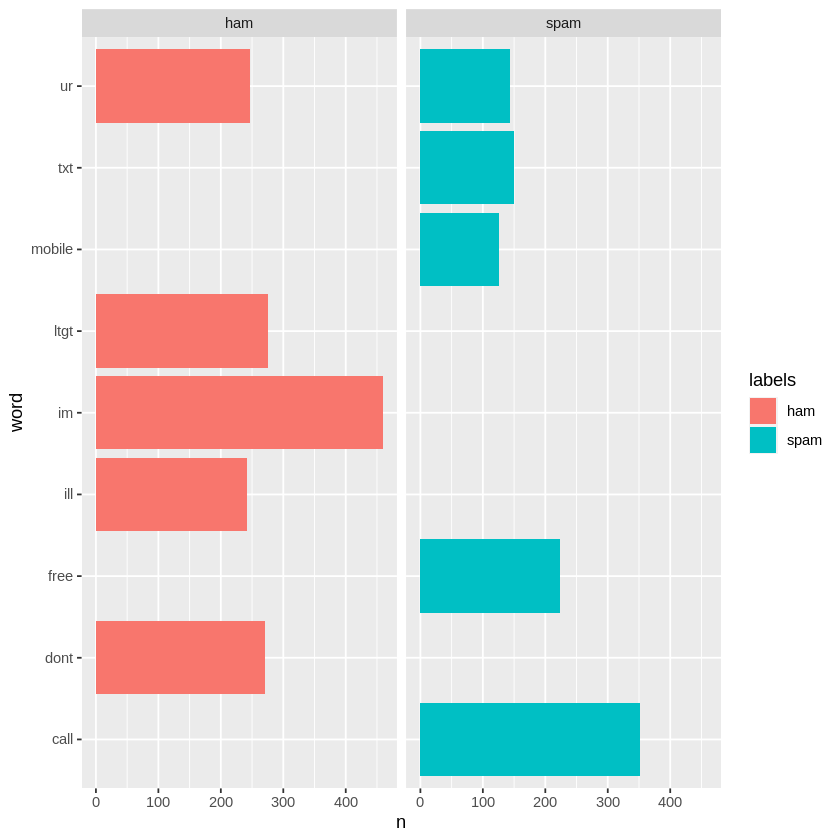

In [ ]:
# Most common words
emails %>% 
  unnest_tokens(word, text) %>% 
  anti_join(stop_words) %>% 
  group_by(labels) %>% 
  count(word, sort=T) %>% 
  top_n(5) %>% 
  arrange(desc(word)) %>% 
  ggplot(aes(word, n, fill=labels)) +
  geom_col() +
  facet_wrap(~labels, ncol=2)+
  coord_flip()


Joining, by = "word"



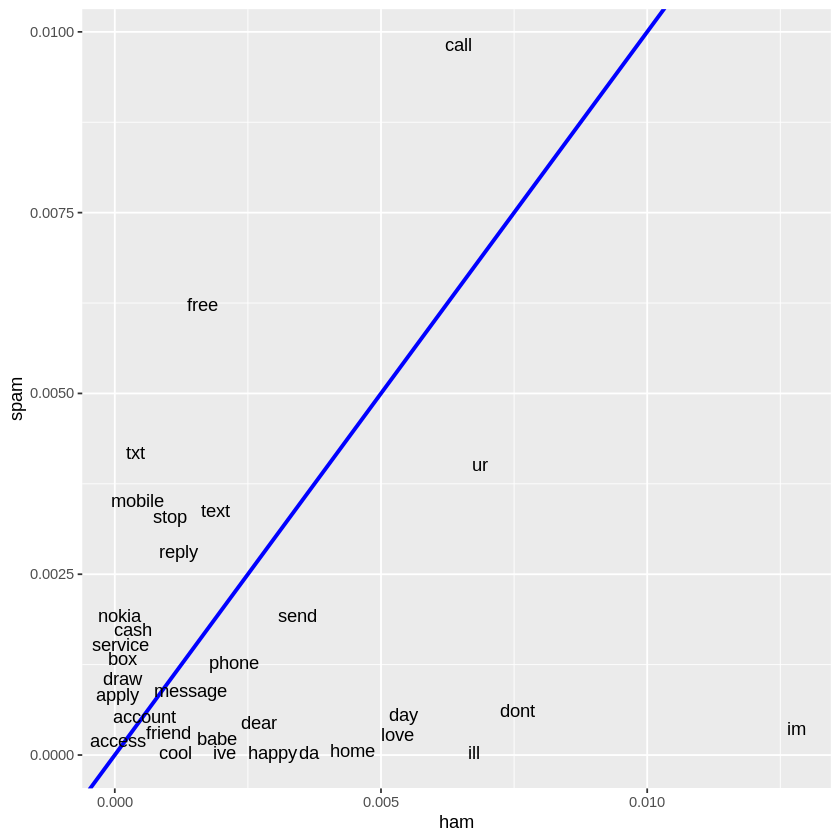

In [ ]:
# Most Common words

d <- emails %>% 
  #group_by(labels) %>% 
  unnest_tokens(word, text) %>% 
  anti_join(stop_words) %>% 
  count(labels, word, sort=T) %>% 
  mutate(prop = n/sum(n)) %>% 
  dplyr::select(-n) %>% 
  spread(labels, prop) %>% 
  ggplot(aes(ham, spam)) + 
  #geom_point(size=2.5)+
  geom_abline(size=1.1, color=I('blue')) +
  geom_text(aes(label=word), check_overlap = T)
d

Joining, by = "word"



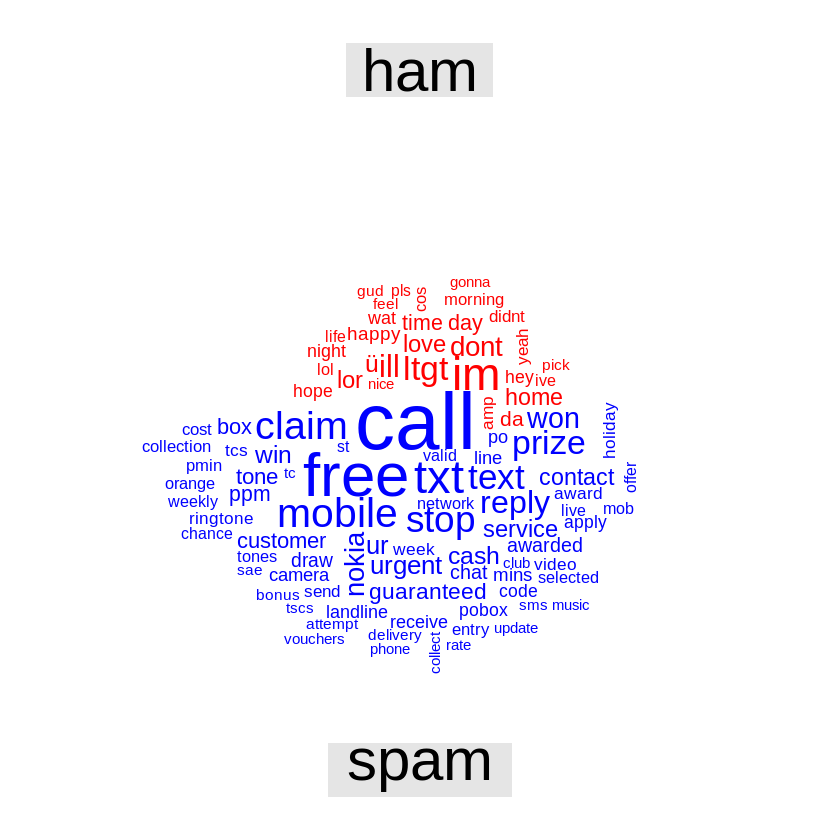

In [ ]:
####  word cloud
emails %>% 
  unnest_tokens(word, text) %>% 
  anti_join(stop_words) %>% 
  group_by(labels) %>% 
  count(word, sort=T) %>% 
# class label distribution
  acast(word~labels, value.var = 'n', fill=0) %>% 
  comparison.cloud(colors=c('red','blue'), max.words=100)


`summarise()` ungrouping output (override with `.groups` argument)



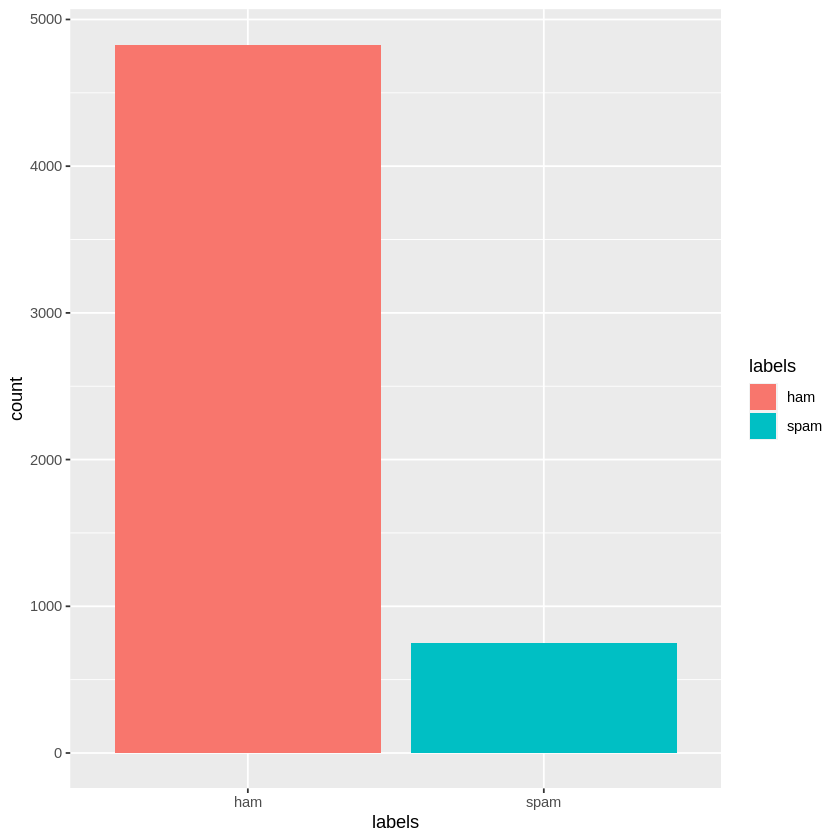

In [ ]:
# Class label Distribution
emails %>% 
  group_by(labels) %>% 
  summarise(count=n()) %>% 
  ggplot(aes(labels, count, fill=labels)) +
  geom_col() 


In [ ]:
# tokenization


word_count <- emails %>% 
  unnest_tokens(word, text) %>% 
  count(documents, word, sort=T) 

word_count

In [ ]:
# Create Document term frequency


data_dtf <- word_count %>% 
  bind_tf_idf(word, documents, n) %>% 
  cast_dtm(documents, word, tf_idf)

data_dtf

<<DocumentTermMatrix (documents: 5576, terms: 8637)>>
Non-/sparse entries: 76018/48083894
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

In [ ]:
# Display its structure
str(data_dtf)

List of 6
 $ i       : int [1:76018] 1 2 8 38 39 42 98 108 119 127 ...
 $ j       : int [1:76018] 1 1 1 1 1 1 1 1 1 1 ...
 $ v       : num [1:76018] 0.863 0.1003 0.1553 0.0336 0.1845 ...
 $ nrow    : int 5576
 $ ncol    : int 8637
 $ dimnames:List of 2
  ..$ Docs : chr [1:5576] "1585" "3023" "1869" "2164" ...
  ..$ Terms: chr [1:8637] "ltgt" "happy" "you" "my" ...
 - attr(*, "class")= chr [1:2] "DocumentTermMatrix" "simple_triplet_matrix"
 - attr(*, "weighting")= chr [1:2] "term frequency" "tf"


In [ ]:
# Meta data

meta <- tibble(documents=as.numeric(dimnames(data_dtf)[[1]])) %>% 
  left_join(emails, by='documents')

meta %>% top_n(4)

Selecting by text



documents,labels,text
<dbl>,<chr>,<chr>
799,ham,ywhere u at dogbreath its just sounding like jan c thats al
1041,ham,zoe it just hit me im fucking shitin myself il defo try my hardest cum morow luv u millions lekdog
2691,ham,yupz ive oredi booked slots my weekends liao
3384,ham,yup wun believe wat u really neva c e msg i sent shuhui


In [ ]:
# Create train and test set
set.seed(1234)
trainIndex <- createDataPartition(meta$documents, p=0.85, list=F, times = 1)

X_train <- data_dtf[trainIndex,] %>% as.matrix() 
X_test <- data_dtf[-trainIndex,] %>% as.matrix()



In [ ]:
X_train[1:10,1:10]

In [ ]:
print(typeof(X_train))

[1] "double"


In [ ]:
# Define models with caret frame work
set.seed(1234)
controls <- trainControl(method = 'repeatedcv', number = 10, search='grid')

y_train <- factor(as.vector(meta[trainIndex,]$labels))
y_train[1:10]
y_test <- factor(as.vector(meta[-trainIndex,]$labels))


[1] ham ham ham ham ham ham ham ham ham ham
Levels: ham spam

[1] 0

In [ ]:
train <- X_train
train['labels_train'] <- y_train
test <- X_test
test['labels_test'] <- y_test

In [ ]:
'labels_train' %in% names(train)

[1] TRUE

In [ ]:
BestParams <- function(object, vect_of_params, p){
  n <- length(vect_of_params)
  
  best_acc = numeric(length = n)
  best_param <- numeric(length = n)
  best_model <- numeric(length = n)
  best <- list(best_acc=best_acc, best_param=best_param, best_model=best_model)

  
  for(i in 1:n){
    model <- object(X_train,y_train, data=train,  p=vect_of_params[i])
    y_pred = predict(model, newdata = X_test)
    acc <- mean(y_pred == y_test)
    best$best_acc[i] <- acc
    best$best_param[i] <- vect_of_params[i]
    best$best_model[i] <- model
  }
  best_index <- which.max(best$best_acc)
  return(list(bestmodel=best$best_model[best_index], bestparam=best$best_param[best_val]))
}

In [ ]:
sample.int(10,3)

[1] 9 5 6

In [ ]:
params <- seq(0,1,length=10)
N <- length(y_train)
prop <- 0.28
val_index <- sample.int(length(y_train), as.integer(prop*N))

In [ ]:
g

[1] 1

In [ ]:
g <- BestParams(svm, params, val_index)
system.time(
  svm_mod <- svm(x=X_train,y=y_train,data=X_train, gamma = g)
)

   user  system elapsed 
 17.695   0.548  18.299 

In [ ]:

# Prediction
svm_pred <- predict(svm_mod,
                    newdata = X_test)
# Confusion Matrix
svm_cm <- confusionMatrix(svm_pred, y_test)
svm_cm
# f1 score
svm_cm$byClass['F1']

In [ ]:
system.time(
  l <- BestParams(naiveBayes, params, val_index)
)

Timing stopped at: 108.5 0.569 109.3



In [ ]:
params <- seq(0,1,length=5)
l <- BestParams(naiveBayes, params, val_index)
system.time(
  nb_mod <- naiveBayes(x=X_train, y=y_train, laplace = l)
)

In [ ]:
# Predictions
system.time(
  nb_pred <- predict(nb_mod,
                   newdata = X_test)
)

# Confusion Matrix
nb_cm <- confusionMatrix(svm_pred, y_test)
nb_cm
# f1 score
nb_cm$byClass['F1']

In [154]:
params <- seq(1,20,2)
system.time(
  t <- BestParams(svm, params)
)

Timing stopped at: 246.6 4.061 251.1



In [ ]:
t

In [ ]:
# library(ranger)
system.time(
  rf_mod <- ranger(x=X_train, y=y_train, data = train, num.trees = t)
)

   user  system elapsed 
 13.241   0.005   9.315 

In [ ]:
# Predictions
rf_pred <- predict(rf_mod, X_test)

# Confusion Matrix
rf_cm <- confusionMatrix(rf_pred$predictions, y_test)
rf_cm
# f1 score
rf_cm$byClass['F1']


Confusion Matrix and Statistics

          Reference
Prediction ham spam
      ham  707   25
      spam   2  102
                                          
               Accuracy : 0.9677          
                 95% CI : (0.9534, 0.9786)
    No Information Rate : 0.8481          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8646          
                                          
 Mcnemar's Test P-Value : 2.297e-05       
                                          
            Sensitivity : 0.9972          
            Specificity : 0.8031          
         Pos Pred Value : 0.9658          
         Neg Pred Value : 0.9808          
             Prevalence : 0.8481          
         Detection Rate : 0.8457          
   Detection Prevalence : 0.8756          
      Balanced Accuracy : 0.9002          
                                          
       'Positive' Class : ham             
                           

F1 
0.981263

In [ ]:
# Combine results for further analysis
mod_results <- bind_rows(svm_cm$overall, 
                         nb_cm$overall,
                         rf_cm$overall) %>% 
  mutate(models=c('SVM', 'NB', 'RF'))
mod_results

Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,models
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.9712919,0.8792184,0.9575844,0.9815214,0.8480861,3.346482e-32,2.667955e-06,SVM
0.9712919,0.8792184,0.9575844,0.9815214,0.8480861,3.346482e-32,2.667955e-06,NB
0.9641148,0.8490230,0.9491661,0.9756599,0.8480861,7.662817e-28,2.678522e-05,RF


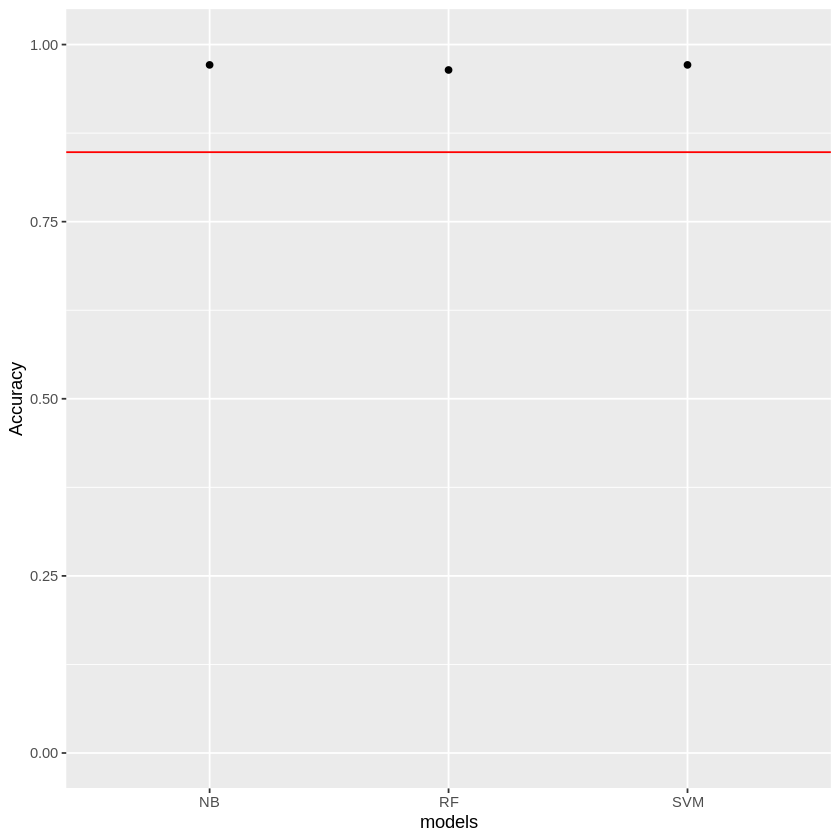

In [ ]:
mod_results %>%
  ggplot(aes(models, Accuracy)) +
  geom_point() +
  ylim(0, 1) +
  geom_hline(yintercept = mod_results$AccuracyNull[1],
             color = "red")

In [ ]:
str(svm_mod)

In [ ]:
results <- resamples(list(SVM=svm_mod, NB=nb_mod, RF=rf_mod))
summary(results)

In [ ]:
di <- diff(results)
summary(di)

In [ ]:
xyplot(results, models=c('SVM','RF'), pch=2)
#splom(results)

In [ ]:
bwplot(results)
#parallelplot(results)

In [ ]:
# dot plots of accuracy
scales <- list(x=list(relation="free"), y=list(relation="free"))
dotplot(results, scales=scales)